In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants

import simdata

%reload_ext autoreload
%autoreload 2
%load_ext line_profiler
from importlib import reload
from pprint import pprint

from simdata_vorticity import provide_simulation_data
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D, show_fit_overview_1D
from src.vortector.contour import detect_elliptic_contours

%matplotlib widget

In [2]:
# big vortex example
# simid = "3625e016"
# Noutput = 200

# # density ring
# simid = "f14ce0ba" ; Noutput = 500; Rlims = [40,75]

# pluto run
# simid = "c5d5e99c"; Noutput = 200; Rlims = [5.2, 15]

# late deep vortex
simid = "5c8cd8da"; Noutput = 755; Rlims = [5.2, 15]

# transition disk
# simid = "d132cf47"; Noutput = 401; Rlims = [40,75]
# simid = "5d2637fd"; Noutput = 701; Rlims = [20,85]

levels = [float(x) for x in np.arange(-1,1.5,0.05)]

Xc, Yc, A, vortensity, vorticity, Rho, Rho_background = provide_simulation_data(simid, Noutput)

## Vorticity calculation for simdata

In [3]:
# import configparser
# conf = configparser.ConfigParser()
# conf["data"] = { 
#     "Nr" : Xc.shape[0],
#     "Nphi" : Xc.shape[1],
#     "r" : "r.dat",
#     "phi" : "phi.dat",
#     "area" : "area.dat",
#     "vortensity" : "vortensity.dat",
#     "density" : "density.dat" }
# conf["parameters"] = {
#     "rmin" : 5.2,
#     "rmax" : 12,
    
# }
# with open("test/test.conf", "w") as conffile:
#     conf.write(conffile)
    
# def write_array_file(name, x):
#     x.astype(np.float64).tofile(name)
    
# write_array_file("test/r.dat", Xc)
# write_array_file("test/phi.dat", Yc)
# write_array_file("test/area.dat", A)
# write_array_file("test/vortensity.dat", vortensity)
# write_array_file("test/density.dat", Rho)

In [7]:
nl = np.argmin(np.abs(Xc[:,0]-Rlims[0]))
nr = np.argmin(np.abs(Xc[:,0]-Rlims[1]))
# nl = 0
# nr = Xc.shape[0]

from scipy.ndimage.filters import gaussian_filter
blur_sigma = 5
if blur_sigma > 0:
    blurred_vortensity = gaussian_filter(vortensity[nl:nr,:], sigma=blur_sigma)
    blurred_density = gaussian_filter(Rho[nl:nr,:], sigma=blur_sigma)
else:
    blurred_vortensity = vortensity[nl:nr,:]
    blurred_density = Rho[nl:nr,:]

levels = [float(x) for x in np.arange(-1,1.5,0.05)]
vd = Vortector(Xc[nl:nr,:], Yc[nl:nr,:], A[nl:nr,:], blurred_vortensity, blurred_density,
                         verbose=True, med=0.15, mear=np.inf,
                         levels=levels
                        )
%time vortices = vd.detect(include_mask=True, keep_internals=False, linear_radius=False, blur=5)
if "fig_vortector_overview_2d" in locals():
    show_fit_overview_2D(vd, bnd_pnts=False, xscale="linear", fig = fig_vortector_overview_2d)


Number of found contours: 49
Number of closed contours: 20
Area of contours: [17003.0, 16830.5, 5223.0, 5223.0, 3493.0, 3493.0, 2737.0, 2737.0, 2509.5, 2509.5, 1818.0, 1818.0, 1278.0, 1278.0, 836.0, 836.0, 458.0, 458.0, 136.0, 136.0]
Removed 9 contours which were duplicates. 11 remaining.
Detected 11 elliptic contours.
Removed 0 candidates by common area and bbox. 11 remaining
Removed 0 candidates by due to vortensity drop < 0.1.
CPU times: user 394 ms, sys: 155 ms, total: 549 ms
Wall time: 212 ms


In [5]:
%matplotlib widget
fig_vortector_overview_2d = plt.figure(figsize=(12,8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
if "fig_vortector_overview_2d" in locals():
    show_fit_overview_2D(vd, bnd_pnts=False, xscale="log", fig = fig_vortector_overview_2d)

In [11]:
for vort in vd.vortices:
    vmin = vort["contour"]["stats"]["vortensity_min"]
    vmed = vort["contour"]["stats"]["azimuthal_at_vortensity_min"]["vortensity_med"]
    print(f"vmin/vmed = {vmin/vmed},  vmed = {vmed}, vmin = {vmin}")
    a = vort["fits"]["vortensity"]["a"]
    c = vort["fits"]["vortensity"]["c"]
    print(f"(c+a)/c = {(c+a)/c}, c = {c}, a = {a}, a+c = {a+c}")
    
    print(vort["fits"]["surface_density"]["properties"])
    print(vort["contour"]["stats"]["mass"])

vmin/vmed = 0.187597768585528,  vmed = 0.5727240997156323, vmin = 0.10744176312180806
(c+a)/c = 0.08215663583294334, c = 0.6528365973498939, a = -0.5992017387630008, a+c = 0.0536348585868931
{'ellipse_area_numerical': 9.911127836553902, 'area_ratio_ellipse_to_contour': 0.4819567521099761, 'contour_diff': 2.6560828568597972e-05, 'contour_reldiff': 0.0225982915417772, 'contour_mass': 8.728803681280727, 'contour_mass_fit': 8.689562228278009, 'ellipse_diff': 1.0485915109882635e-05, 'ellipse_reldiff': 0.018511101276523452, 'ellipse_mass': 2.497546432696156, 'ellipse_mass_fit': 2.482984927506344}
0.0010592405162719574
vmin/vmed = 0.187597768585528,  vmed = 0.5727240997156323, vmin = 0.10744176312180806
(c+a)/c = 0.08215663583294334, c = 0.6528365973498939, a = -0.5992017387630008, a+c = 0.0536348585868931
{'ellipse_area_numerical': 9.911127836553902, 'area_ratio_ellipse_to_contour': 0.4819567521099761, 'contour_diff': 2.6560828568597972e-05, 'contour_reldiff': 0.0225982915417772, 'contour_ma

In [9]:
vort = vd.vortices[0]

X, Y, Zv, Zd, mask = vd.extract_data(vort, region="combined")

N_levels = min(int(np.min(Zd.shape)/2), 15)
print(N_levels)
levels_d = np.linspace(np.min(Zd), np.max(Zd), N_levels)
levels_v = np.arange(-1, 1, 0.05)

15


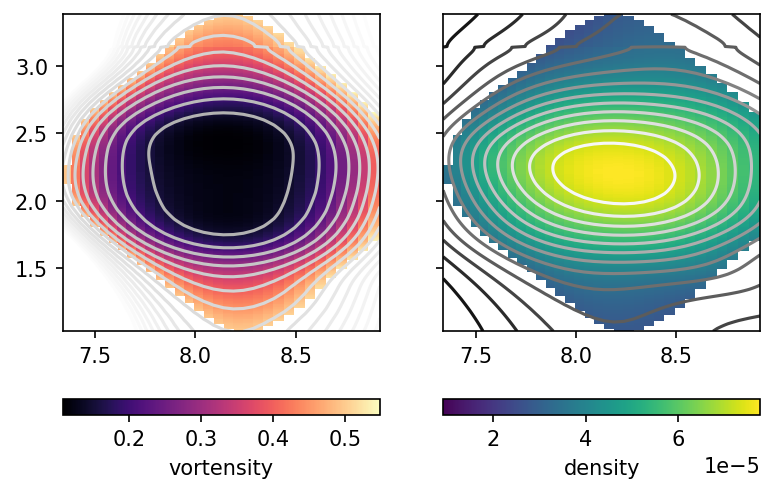

In [10]:
%matplotlib inline
def colormesh_plot(ax, X , Y, Z, levels, label, cmap="viridis", vlim=None):
    if vlim is None:
        vlim = (levels[0], levels[-1])
    im = ax.pcolormesh(X, Y, Z, vmax=vlim[1], vmin=vlim[0], cmap=cmap)
    ax.contour(X,Y,Z,cmap="Greys_r", levels=levels)
    cbar = ax.get_figure().colorbar(im, ax=ax, orientation="horizontal")
    cbar.set_label(label)
    ax.pcolormesh(X, Y, np.ma.masked_array(np.ones(Z.shape), mask=mask), cmap="binary")

fig, axes = plt.subplots(1,2,dpi=150, sharex="all", sharey="all")
colormesh_plot(axes[0], X, Y, Zv, levels_v, "vortensity", cmap="magma", vlim=[np.min(Zv[mask]), np.max(Zv[mask])])
colormesh_plot(axes[1], X, Y, Zd, levels_d, "density")

# im_d = axes[1].pcolormesh(X, Y, Zd, vmax=levels_d[-1], vmin=levels_d[0])
# axes[1].contour(X,Y,Zd,cmap="Greys_r", levels=levels_d)
# cbar_d = fig.colorbar(im_d, ax=axes[1], orientation="horizontal")
# cbar_d.set_label("density")

In [11]:
%time cnts = detect_elliptic_contours(Zd, levels_d, 10, 2, verbose=False, periodic=False);

CPU times: user 72.9 ms, sys: 1.05 ms, total: 74 ms
Wall time: 65.9 ms


In [12]:
Ns = cnts[0]["detection"]["descendants"]
dSigma = len(Ns)*(levels[1]-levels[0])
print(Ns, dSigma)

[8, 9, 10, 11, 12, 13, 14, 15] 0.40000000000000036


In [13]:
# %matplotlib widget
# for cnt in cnts:
#     fig, ax = plt.subplots(dpi=150)
#     ax.pcolormesh(X, Y, cnt["mask"])
# #     ax.imshow(cnt["mask"])
#     ax.set_title(f'{cnt["detection"]["opencv_contour_number"]}')

In [14]:
cnts[0]

{'detection': {'boundary': array([[[657, 322]],
  
         [[658, 321]],
  
         [[659, 321]],
  
         ...,
  
         [[654, 322]],
  
         [[655, 322]],
  
         [[656, 322]]], dtype=int32),
  'opencv_contour_number': 7,
  'pixel_area': 411477.5,
  'pixel_arcLength': 2587.6479610204697,
  'bounding_hor_img': array([1159,  168], dtype=int32),
  'bounding_vert_img': array([321, 835], dtype=int32),
  'bottom_img': (727, 835),
  'top_img': (658, 321),
  'left_img': (168, 552),
  'right_img': (1159, 546),
  'dx_img': 991,
  'dy_img': 514,
  'ellipse': {'center_img': (679.6181640625, 574.9690551757812),
   'axesLengths_img': (520.6613159179688, 1009.9378051757812),
   'angle_img': 90.16312408447266},
  'mask_img': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int8),
  'ellipse_area_delta_relative': 

In [15]:
for vort in vd.vortices:
    vmin = vort["contour"]["stats"]["vortensity_min"]
    vmed = vort["contour"]["stats"]["azimuthal_at_vortensity_min"]["vortensity_med"]
    print(vmin, vmed, vmin/vmed)
    print(vort["fits"]["surface_density"]["properties"])

0.10744176312180806 0.5727240997156323 0.187597768585528
{'ellipse_area_numerical': 9.875149119366805, 'area_ratio_ellipse_to_contour': 0.4619878668785553, 'contour_diff': 2.8065084467143363e-05, 'contour_reldiff': 0.023026086065987564, 'contour_mass': 9.3144066506768, 'contour_mass_fit': 9.269570929804505, 'ellipse_diff': 1.0617815972958494e-05, 'ellipse_reldiff': 0.018856383141065258, 'ellipse_mass': 2.4813182174862423, 'ellipse_mass_fit': 2.4667880357679435}


In [16]:
Zd

array([[9.16454084e-06, 9.19844775e-06, 9.23336007e-06, ...,
        1.07028462e-05, 1.06314932e-05, 1.05612758e-05],
       [1.01479465e-05, 1.01885367e-05, 1.02302268e-05, ...,
        1.15830873e-05, 1.15064895e-05, 1.14312464e-05],
       [1.12123091e-05, 1.12600013e-05, 1.13088695e-05, ...,
        1.24954824e-05, 1.24142794e-05, 1.23346192e-05],
       ...,
       [2.28061269e-05, 2.28724949e-05, 2.29413114e-05, ...,
        2.34748139e-05, 2.33979744e-05, 2.33230154e-05],
       [2.24819816e-05, 2.25511470e-05, 2.26226488e-05, ...,
        2.26275662e-05, 2.25636847e-05, 2.25016003e-05],
       [2.22177623e-05, 2.22883183e-05, 2.23610539e-05, ...,
        2.18807207e-05, 2.18297186e-05, 2.17803543e-05]])

<AxesSubplot:>

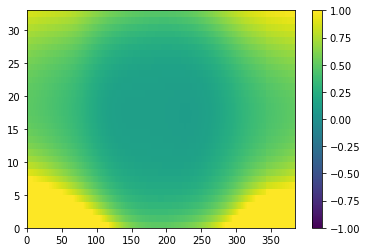

In [17]:
def show_array(A, ax = None, vmin=None, vmax=None):
    if ax is None:
        _, ax = plt.subplots()
    im = ax.pcolormesh(A, vmin=vmin, vmax=vmax)
    ax.get_figure().colorbar(im, ax=ax)
    return ax
show_array(Zv, vmin=-1, vmax=1)

In [18]:
bins = np.arange(-1, 1+1e-10, 0.1)
bins[0] = -np.inf
bins[-1] = np.inf
Zv_dig = np.digitize(Zv, bins)

<AxesSubplot:>

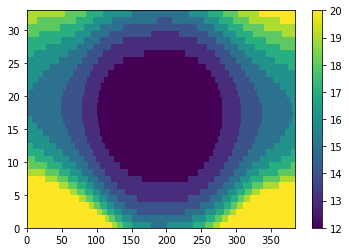

In [19]:
show_array(Zv_dig)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

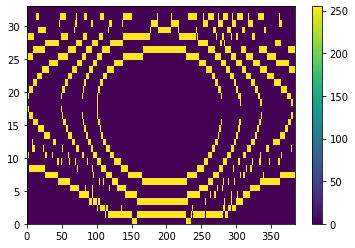

In [20]:
edges = cv2.Canny((Zv_dig/len(bins)*255).astype(np.uint8), 1, 32)
show_array(edges)
edges

Number of Contours is: 2
Showed 2 contours


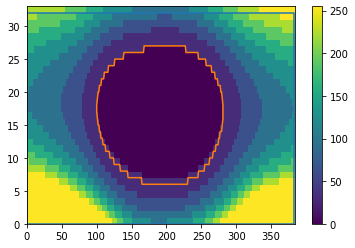

In [21]:
import cv2
# Find Contours
image = Zv_dig - np.min(Zv_dig)
image = image / np.max(image) * 255
image = image.astype(np.uint8).copy()
contours, hierarchy = cv2.findContours(image,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Find Number of contours
print("Number of Contours is: " + str(len(contours)))
# Draw yellow border around two contours
# cv2.drawContours(image, contours, -1, (0, 230, 255), 1)
# cv2.drawContours(image, contours, 2, (0, 230, 255), 6)
# Show the image with contours
def show_contour(ax, c, **kwargs):
    x = c[:,0,0]
    y = c[:,0,1]
    ax.plot(x,y,**kwargs)
    
ax = show_array(image)
n = 0
for c in contours:
    l = cv2.arcLength(c, True)
    a = cv2.contourArea(c, )
    if l <= 0 or a < l:
        continue
    n += 1
    show_contour(ax, c)
print(f"Showed {n} contours")

In [37]:
%matplotlib inline
def extract_contour(data, thresh, show=True):
# Find Contours
    image = data < thresh
    image = image / np.max(image) * 255
    image = image.astype(np.uint8).copy().T
    contours, hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Find Number of contours
    print(f"For thesh {thresh:.1f}, number of Contours is: " + str(len(contours)))
    # Draw yellow border around two contours
    # cv2.drawContours(image, contours, -1, (0, 230, 255), 1)
    # cv2.drawContours(image, contours, 2, (0, 230, 255), 6)
    # Show the image with contours
    if show:
        def show_contour(ax, c, **kwargs):
            x = c[:,0,0]
            y = c[:,0,1]
            ax.plot(x,y,**kwargs)

        ax = show_array(image)
        n = 0
        for c in contours:
            l = cv2.arcLength(c, True)
            a = cv2.contourArea(c, )
            if l <= 0 or a < l:
                continue
            n += 1
            show_contour(ax, c)
        ax.set_title(f"Showed {n} contours for thresh {thresh}")
    return contours

For thesh 0.6, number of Contours is: 3


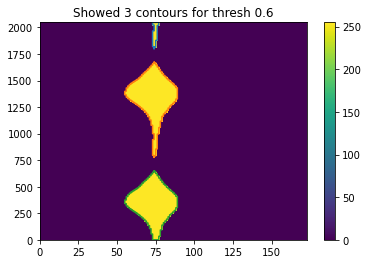

In [38]:
Nx, Ny = blurred_vortensity.shape
extended_image = np.pad(blurred_vortensity, ((0, 0), (Ny//2, Ny//2)), mode="wrap")#.copy()
# extended_image = blurred_vortensity

extract_contour(extended_image, 0.6, show=True);

For thesh -1.0, number of Contours is: 0
For thesh -0.9, number of Contours is: 0
For thesh -0.9, number of Contours is: 0
For thesh -0.8, number of Contours is: 0
For thesh -0.8, number of Contours is: 0
For thesh -0.7, number of Contours is: 0
For thesh -0.7, number of Contours is: 0
For thesh -0.6, number of Contours is: 0
For thesh -0.6, number of Contours is: 0
For thesh -0.5, number of Contours is: 0
For thesh -0.5, number of Contours is: 0
For thesh -0.4, number of Contours is: 0
For thesh -0.4, number of Contours is: 0
For thesh -0.3, number of Contours is: 0
For thesh -0.3, number of Contours is: 0
For thesh -0.2, number of Contours is: 0
For thesh -0.2, number of Contours is: 0
For thesh -0.1, number of Contours is: 0
For thesh -0.1, number of Contours is: 0
For thesh -0.0, number of Contours is: 0
For thesh 0.0, number of Contours is: 0
For thesh 0.1, number of Contours is: 0
For thesh 0.1, number of Contours is: 0
For thesh 0.2, number of Contours is: 2
For thesh 0.2, numbe

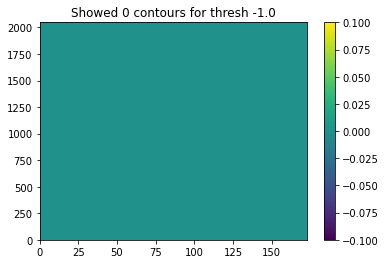

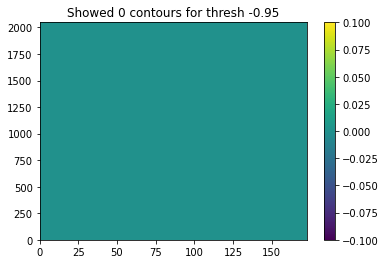

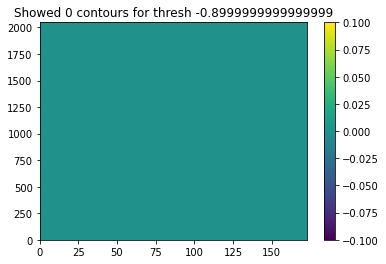

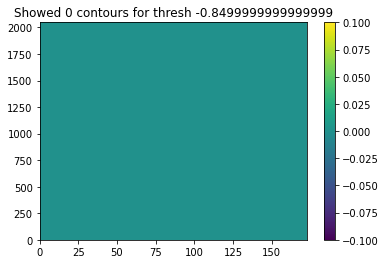

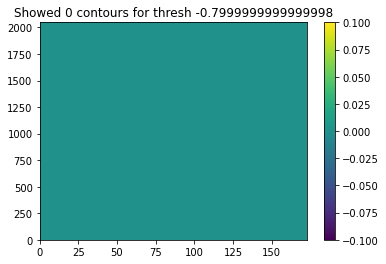

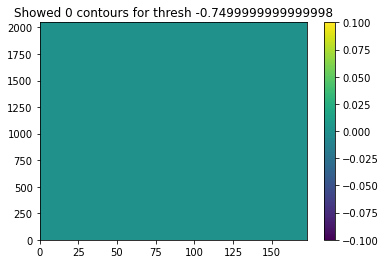

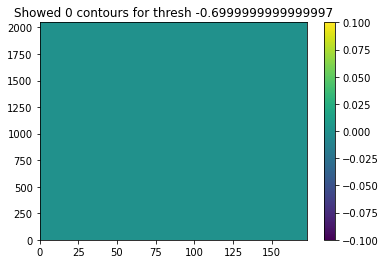

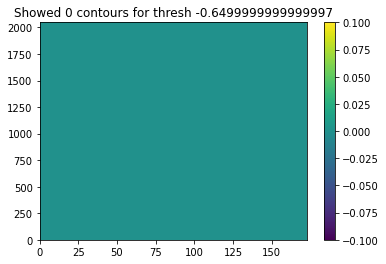

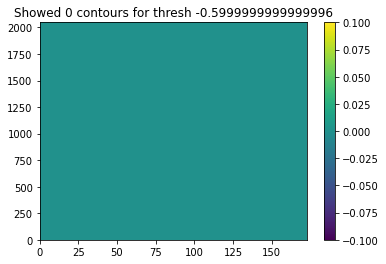

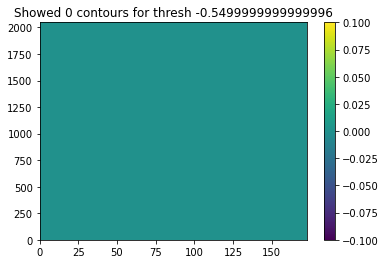

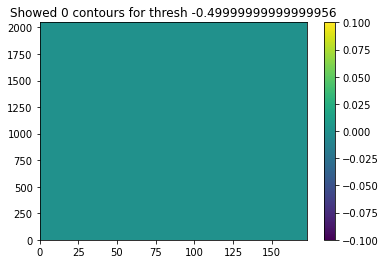

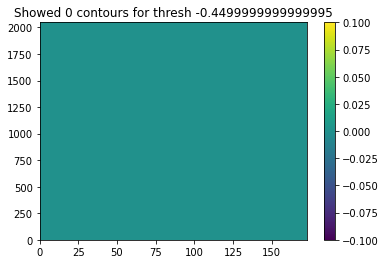

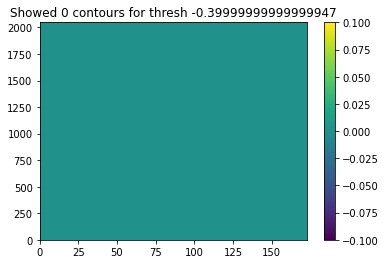

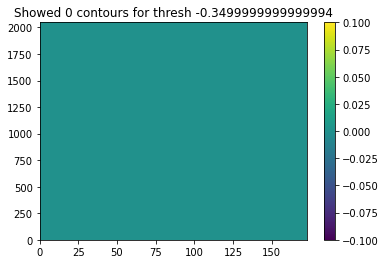

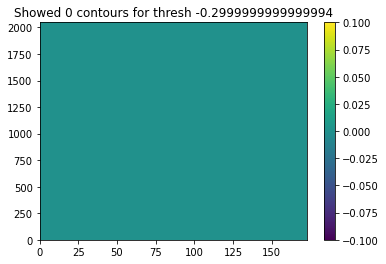

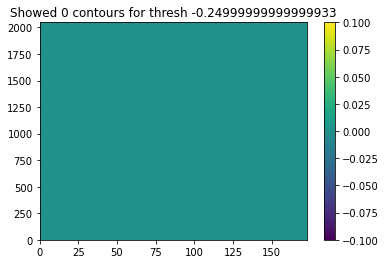

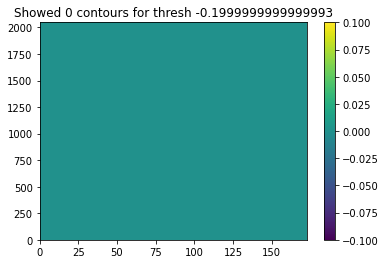

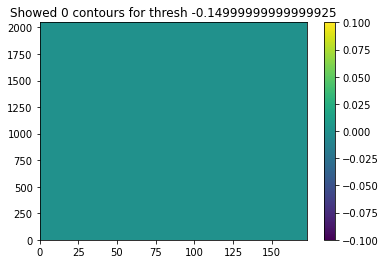

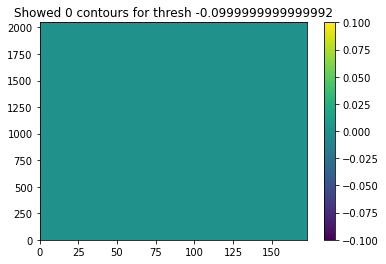

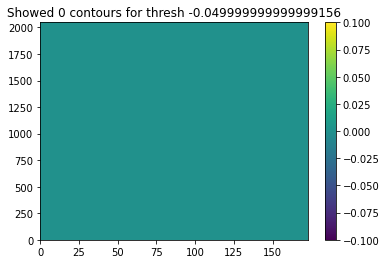

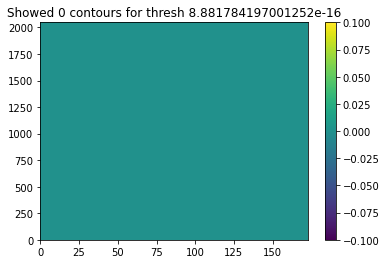

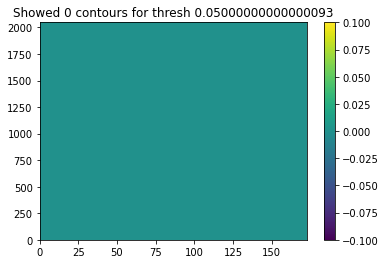

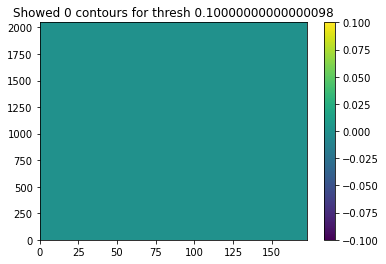

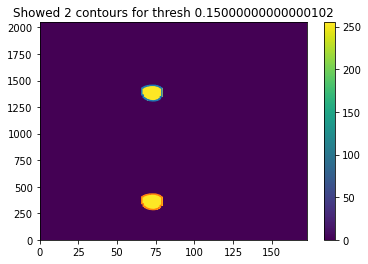

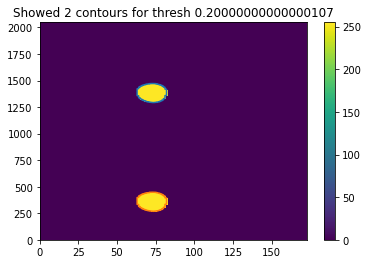

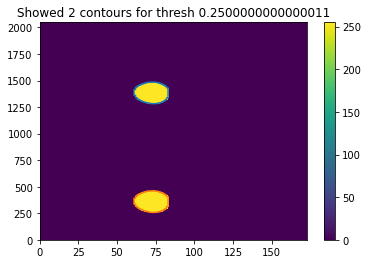

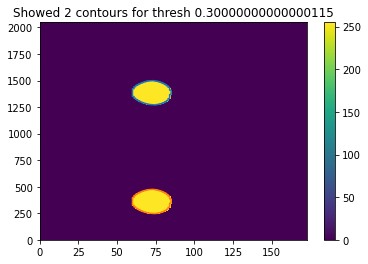

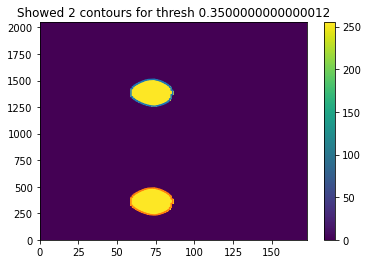

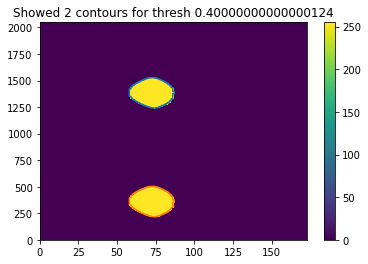

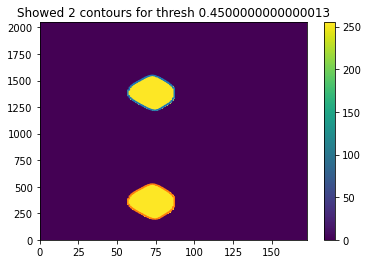

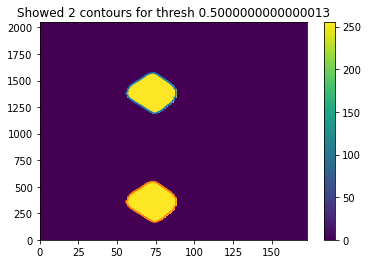

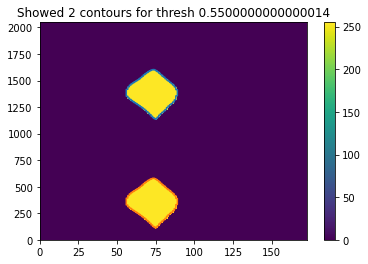

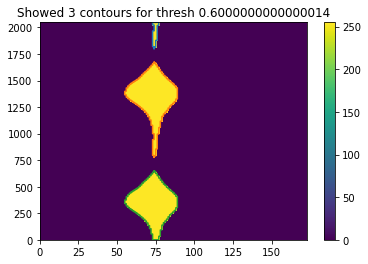

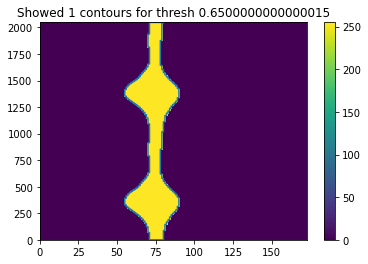

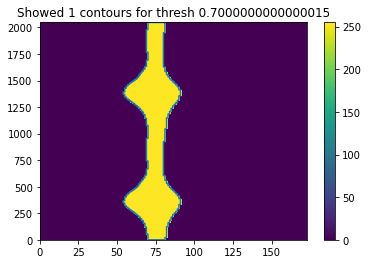

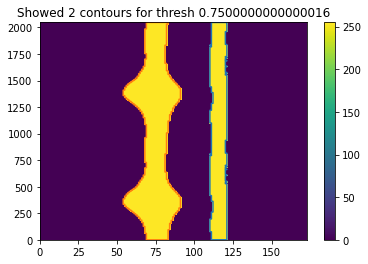

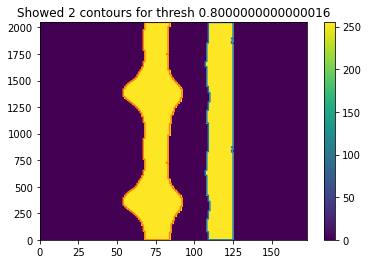

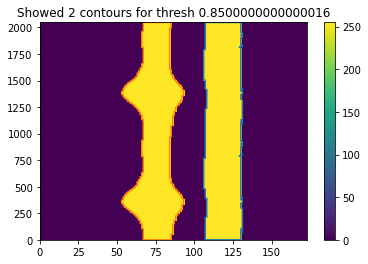

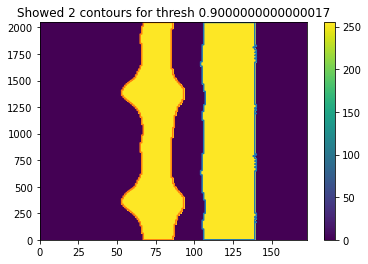

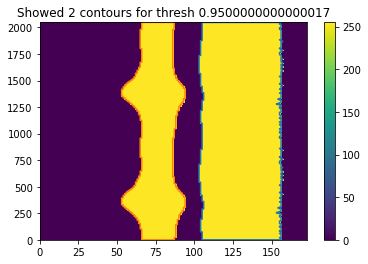

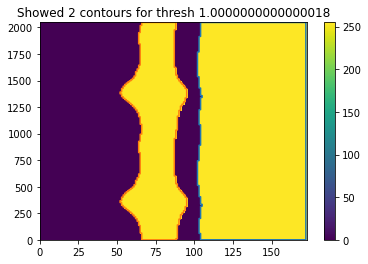

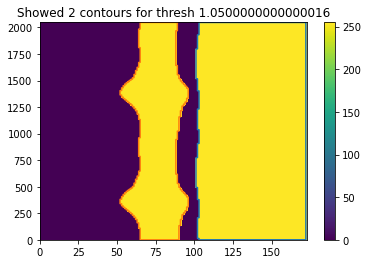

In [47]:
%%time
for th in np.arange(-1,1.1,0.05):
    extract_contour(extended_image, th, show=True)

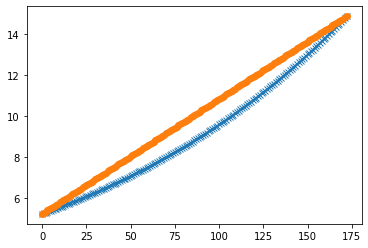

In [116]:
r = vd.radius[:,0]
fig, ax = plt.subplots()
ax.plot(r, "-x")
rlin = np.linspace(r[0], r[-1], len(r))
ax.plot(rlin, "-o")

In [31]:
def interpolation_indices_weights(x, y):
    indices = np.zeros((len(x), 2), dtype=np.int32)
    weights = np.zeros((len(x), 2), dtype=np.float64)
    indices[0] = [0, 0]
    weights[0] = [0.5, 0.5]
    for n in range(1, len(x)):
        for k in range(indices[0, 0], len(x)):
            nup = k
            if y[nup] >= x[n]:
                break
        for k in range(nup, -1, -1):
            nlow = k
            if y[nlow] <= x[n]:
                break
        if nlow >= nup:
            weights[n, :] = [0.5, 0.5]
            indices[n, :] = [n, n]
        else:
            wup = (x[n] - y[nlow]) / (y[nup] - y[nlow])
            wlow = (y[nup] - x[n]) / (y[nup] - y[nlow])
            weights[n, :] = [wlow, wup]
            indices[n, :] = [nlow, nup]
    return indices, weights
rs = vd.radius[:,0]
rlin = np.linspace(rs[0], rs[-1], len(rs))
inds, ws = interpolation_indices_weights(rs, rlin)

In [32]:

fig, ax = plt.subplots()
rs = vd.radius[:,0]
ax.plot(rs, "-x")
rlin = np.linspace(rs[0], rs[-1], len(rs))
ax.plot(rlin, "o")
# ax.plot([rlin[i[0]]*w[1] + rlin[i[1]]*w[0] for i, w in zip(inds, ws)], "-o")
for n, i, w in zip(range(len(inds)), inds, ws):
    nlow = i[0]
    nup = i[1]
    ax.plot([nlow, n], [rlin[nlow], rs[n]], color=f"C{n%3}")
    ax.plot([nup, n], [rlin[nup], rs[n]], color=f"C{n%3}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
fig, ax = plt.subplots()
ax.plot(rlin, "-x")
ax.plot([rlin[i[0]]*w[0] + rlin[i[1]]*w[1] for i, w in zip(inds, ws)], "-o")
inds_lin2arb, ws_lin2arb = interpolation_indices_weights(rs, rlin)
r_recon = [rlin[i[0]]*w[0] + rlin[i[1]]*w[1] for i,w in zip(inds_lin2arb, ws_lin2arb)]
ax.plot(r_recon, "r-d")
ax.plot(rs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
fig, ax = plt.subplots()
ax.pcolormesh(vd.radius, vd.azimuth, vd.vortensity, vmin=-1, vmax=1)
ax.set_xscale("log")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …